<a href="https://colab.research.google.com/github/augustosma/antenas/blob/main/PyNEC_dipolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulações usando o PyNEC, versão reescrita do NEC2 em c++ com uma interface em Python 

Fontes para mais informação e outros exemplos:

Repositório do programa: https://github.com/tmolteno/python-necpp

Documentação da API : http://tmolteno.github.io/necpp/annotated.html

No manual do NEC "original" : https://www.nec2.org/other/nec2prt3.pdf

Para executar uma célula basta apertar no play no canto superior esquerda da respectiva célula.
 


# Simulação de antenas com PyNEC

Instalação do PyNEC na máquina virtual

Sempre que se iniciar a máquina virtual, é necessário instalar a biblioteca.

In [4]:
 #%pip install necpp
 !pip install PyNEC==1.7.3.4

Importação de bibliotecas e definição de funções

A operação do programa originalmente se baseava em inserir cartões com os dados da geometria do problema, da fonte de excitação, parâmetros do chão, quais quantidades calcular e com que precisão, entre outros. Por isso, configurar a simulação consiste em chamar funções para cada um desses cartões, fornecendo como parâmetros os valores que eram escritos naqueles cartões.

In [6]:
from PyNEC import *

import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def geometry_monopole(freq, base, length):
    conductivity = 1.45e6 # Stainless steel
    ground_conductivity = 0.002
    ground_dielectric = 10

    wavelength = 3e8/(1e6*freq)
    n_seg = int(math.ceil(50*length/wavelength))

    #nec = context_clean(nec_context())
    nec = nec_context()

    geo = nec.get_geometry()
    geo.wire(1, n_seg, 0, 0, base, 0, 0, base+length, 0.002, 1.0, 1.0)
    nec.geometry_complete(1)

    nec.ld_card(5, 0, 0, 0, conductivity, 0.0, 0.0)
    nec.gn_card(0, 0, ground_dielectric, ground_conductivity, 0, 0, 0, 0)    
    nec.fr_card(0, 1, freq, 0)

    # Voltage excitation one third of the way along the wire
    nec.ex_card(0, 0, int(n_seg/3), 0, 1.0, 0, 0, 0, 0, 0)

    return nec
    
    
def geometry_dipole(freq, x,y,z, length):
    """
    dipolo ao longo do eixo z, centrado em (x,y,z) de comprimento "length"
    """
    conductivity = 1.45e6 # Stainless steel
    ground_conductivity = 0.002
    ground_dielectric = 10
    wire_radius = 0.002

    wavelength = 3e8/(1e6*freq)
    n_seg = int(math.ceil(50*length/wavelength))

    nec = nec_context()

    geo = nec.get_geometry()
    geo.wire(1, n_seg, x, y,-length/2 + z, x, y, length/2 + z, wire_radius, 1.0, 1.0)
    nec.geometry_complete(1)

    nec.ld_card(5, 0, 0, 0, conductivity, 0.0, 0.0)
    #nec.gn_card(0, 0, ground_dielectric, ground_conductivity, 0, 0, 0, 0)
    nec.gn_card(-1, 0, 0, 0, 0, 0, 0, 0) #no ground, free space
    nec.fr_card(0, 1, freq, 0)

    # Voltage excitation one third of the way along the wire
    nec.ex_card(0, 0, int(n_seg/2), 0, 1.0, 0, 0, 0, 0, 0)

    return nec

def geometry_dipole_array(freq, x,y,z, length,d):
    """
    dipolos ao longo do eixo z, centrado em (x,y,z) de comprimento "length" e separados por d
    """
    conductivity = 1.45e6 # Stainless steel
    ground_conductivity = 0.002
    ground_dielectric = 10
    wire_radius = 0.002

    wavelength = 3e8/(1e6*freq)
    n_seg = int(math.ceil(50*length/wavelength))

    nec = nec_context()

    geo = nec.get_geometry()
    geo.wire(1, n_seg, x, y,-length/2 + z, x, y, length/2 + z, wire_radius, 1.0, 1.0)
    geo.wire(2, n_seg, x+d, y,-length/2 + z, x+d, y, length/2 + z, wire_radius, 1.0, 1.0)
    nec.geometry_complete(1)

    nec.ld_card(5, 0, 0, 0, conductivity, 0.0, 0.0)
    #nec.gn_card(0, 0, ground_dielectric, ground_conductivity, 0, 0, 0, 0)
    nec.gn_card(-1, 0, 0, 0, 0, 0, 0, 0) #no ground, free space
    nec.fr_card(0, 1, freq, 0)

    # Voltage excitation one third of the way along the wire
    nec.ex_card(0, 1, int(n_seg/2), 0, 1.0, 0, 0, 0, 0, 0)
    nec.ex_card(0, 2, int(n_seg/2), 0, 1.0, 0, 0, 0, 0, 0)

    return nec     


def plot_rd(nec):
    rp = nec.get_radiation_pattern(0)
    # Gains are in decibels
    gains_db = rp.get_gain()
    gains = 10.0**(gains_db / 10.0)
    thetas = rp.get_theta_angles() * 3.1415 / 180.0
    phis = rp.get_phi_angles() * 3.1415 / 180.0
    
    #TODO transformar coordendas da antena para coordenadas da simulação
    
    
    
    fig,(ax,ax2) = plt.subplots(2,1)
    ax = fig.add_subplot(2,1,1,polar=True)    
    ax.plot(phis, gains[90,:], color='r', linewidth=3)
    ax.grid(True)
    ax.set_title("Gain at theta = 90º ", va='bottom')
    plt.savefig('RadiationPattern.png')
        
    ax2 = fig.add_subplot(2,1,2,polar=True)
    ax2.plot(thetas, gains[:,0], color='r', linewidth=3)
    ax2.plot(-thetas, gains[:,180], color='r', linewidth=3)    
    ax2.grid(True)
    ax2.set_title("Gain at phi = 0º ", va='bottom')
    plt.savefig('RadiationPattern2.png')
     
 
def plot3d(nec):
    """
    
    """
    rp = nec.get_radiation_pattern(0)
    # Gains are in decibels
    gains_db = rp.get_gain()
    gains = 10.0**(gains_db / 10.0)
    thetas = rp.get_theta_angles() * 3.1415 / 180.0
    phis = rp.get_phi_angles() * 3.1415 / 180.0
   
    #theta = polar angle, measured from z
    #phi = azimuthal angle, measured from x 
    thetaSize = gains.shape[0] 
    phiSize = gains.shape[1]      
    
    X = np.ones((thetaSize,phiSize))
    Y = np.ones((thetaSize,phiSize))
    Z = np.ones((thetaSize,phiSize))
    
    #transform spherical to cartesian and fill matrix for plotting
    R = gains    
    for phi_i in range(phiSize):
        for theta_i in range(thetaSize):
                                    
            x = R[theta_i,phi_i] * np.sin(thetas[theta_i]) * np.cos(phis[phi_i])
            y = R[theta_i,phi_i] * np.sin(thetas[theta_i]) * np.sin(phis[phi_i])
            z = R[theta_i,phi_i] * np.cos(thetas[theta_i])
                        
            X[theta_i,phi_i] = x
            Y[theta_i,phi_i] = y
            Z[theta_i,phi_i] = z
    
    v = gains
    v_max = np.max(v)
    my_cm = cm.jet(v/v_max)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_surface(X,Y,Z, facecolors = my_cm, rstride=2, cstride=2 )#cmap=plt.get_cmap('jet'))
    
    ax.grid(True)
    ax.axis('on')    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ganho')
        
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(R)    
    fig.colorbar(m, shrink=0.8)
    ax.view_init(azim=300, elev = 30)
   
    
def plot_gain_vs_frequency_dipolo(f_init,f_final,f_step):
    """
    dipolo de 1m
    """

    freq = []	
    gains_f = []
    real_impedance_f = []
    imag_impedance_f = []

    for f in range(f_init, f_final, f_step):
        nec = geometry_dipole(f,0,0,1.0, 1.0)
        nec.rp_card(calc_mode=0, n_theta=181, n_phi=361, output_format=0, normalization=0, D=0, A=0, theta0=0, delta_theta=1, phi0=0, delta_phi=1, radial_distance=0, gain_norm=0)
        gains = 10.0**(nec.get_radiation_pattern(0).get_gain() / 10.0)
        max_gain = np.max(gains)
        
        freq.append(f)
        gains_f.append(max_gain)
        real_impedance_f.append(get_impedance(nec).real)
        imag_impedance_f.append(get_impedance(nec).imag)
          
    
    fig,(ax,ax2) = plt.subplots(2,1)
    ax.plot(freq,gains_f)
    ax.grid(True)    
    ax.set_title("gains", va='bottom')    

    ax2.plot(freq,real_impedance_f,label='Z_real')
    ax2.plot(freq,imag_impedance_f,label='Z_imag')
    ax2.grid(True)
    ax2.set_title("impedance", va='bottom')
    ax2.legend()  
       
    
def get_impedance(nec):
    ipt = nec.get_input_parameters(0)
    return ipt.get_impedance()
    







Simulação de um dipolo

Impedance is [721.36919502-826.02152297j]


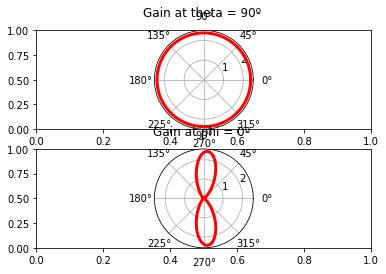

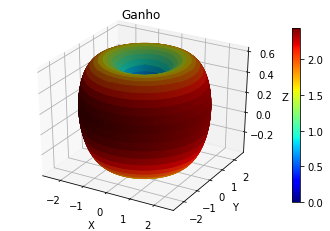

In [8]:
if __name__ == "__main__":
    #freq in MHz
    #nec = geometry_monopole(freq=300.0, base=0, length=1.0)
    nec = geometry_dipole(freq=300.0, x=0,y=0,z=1, length=1.0)
    #nec = geometry_dipole_array(freq=300.0, x=0,y=0,z=1, length=1.0, d=0.25 )
        
    #D=0 -> gain
    #D=1 -> directivity
    nec.rp_card(calc_mode=0, n_theta=181, n_phi=361, output_format=0, normalization=0, D=0, A=0, theta0=0, delta_theta=1, phi0=0, delta_phi=1, radial_distance=0, gain_norm=0)
    #nec.xq_card(0) # Execute simulation, not needed if there is a rp_card
    
    z = get_impedance(nec)    
    print("Impedance is {}".format(z))    

    plot_rd(nec)
    plot3d(nec)    
    plt.show()

Simulação em função da frequência

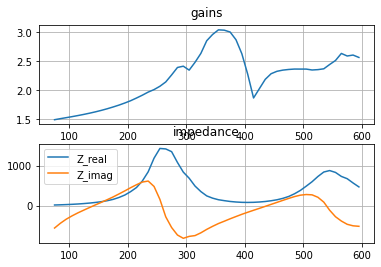

In [9]:
#dipolo com 1.0m de comprimento, espaçamento de 0.25m
plot_gain_vs_frequency_dipolo(f_init=75,f_final=600,f_step=10)
plt.show()

Simulação de um array de dipolos

Impedance is [651.63675891-516.06341519j 651.63675891-516.06341519j]


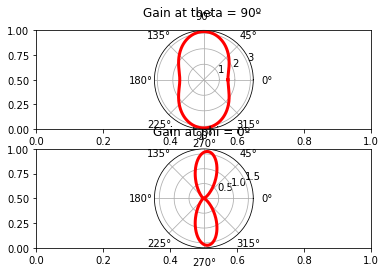

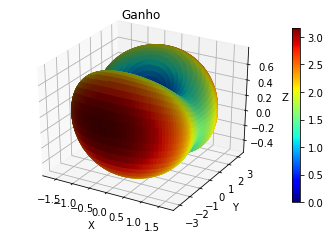

In [10]:
#freq in MHz
nec = geometry_dipole_array(freq=300.0, x=0,y=0,z=1, length=1.0, d=0.25 )
        
#D=0 -> gain
#D=1 -> directivity
nec.rp_card(calc_mode=0, n_theta=181, n_phi=361, output_format=0, normalization=0, D=0, A=0, theta0=0, delta_theta=1, phi0=0, delta_phi=1, radial_distance=0, gain_norm=0)
#nec.xq_card(0) # Execute simulation, not needed if there is a rp_card
    
z = get_impedance(nec)    
print("Impedance is {}".format(z))    

plot_rd(nec)
plot3d(nec)    
plt.show()